# E-commerce Feedback Classifier using IBM Granite

**Project:** HACKTIV8 Capstone Project - Student Developer Initiative  

**Author:** Alettadhira Syasyah

**Objective:** This notebook demonstrates the use of the IBM Granite large language model to perform sentiment analysis on e-commerce customer reviews. The goal is to classify feedback as 'Positive', 'Neutral', or 'Negative' to derive business insights.

## 1. Setup Environment

This section installs and imports all the necessary libraries required for the project. We use `transformers` from Hugging Face to interact with the AI model and `pandas` for data manipulation.

In [2]:
# Install required libraries from Hugging Face for model interaction and PyTorch
!pip install transformers torch accelerate

In [3]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

## 2. Data Loading and Preparation

We will load the dataset from its public GitHub repository. To prepare the data for our classification task, we will map the original 1-5 star ratings to three distinct sentiment labels:
- **Positive:** 4 or 5 stars
- **Neutral:** 3 stars
- **Negative:** 1 or 2 stars

In [4]:
url = 'https://raw.githubusercontent.com/alesyasyah/ecommerce-feedback-classifier-ibm-granite/main/datasets/train.csv'
df = pd.read_csv(url)

print(df.head())

   review_id                                             review  rating
0          0  Ga disappointed neat products .. Meletot Hilsn...       1
1          1    Rdtanya replace broken glass, broken chargernya       1
2          2  Nyesel bngt dsni shopping antecedent photo mes...       1
3          3      Sent a light blue suit goods ga want a refund       1
4          4  Pendants came with dents and scratches on its ...       1


Sentiment Mapping

In [5]:
def map_sentiment(rating):
    if rating in [4, 5]:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # ratings 1, 2
        return 'Negative'

# Apply the function to the 'rating' column to create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

print("Data head after adding 'sentiment' column:")
df.head()

Data head after adding 'sentiment' column:


,review_id,review,rating,sentiment
0,0,Ga disappointed neat products .. Meletot Hilsn...,1,Negative
1,1,"Rdtanya replace broken glass, broken chargernya",1,Negative
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1,Negative
3,3,Sent a light blue suit goods ga want a refund,1,Negative
4,4,Pendants came with dents and scratches on its ...,1,Negative


## 3. Sampling the Data

To manage computation time and resource usage within the Google Colab environment, we will perform our analysis on a representative sample of the data. A `random_state` is used to ensure that our sample is the same every time we run the notebook, making our results reproducible.

In [6]:
# For demonstration, we'll create a small sample of 500 reviews
sample_df = df.sample(500, random_state=42)
print("Sample of data to be classified:")
print(sample_df[['review', 'sentiment']])

Sample of data to be classified:
                                                   review sentiment
131527   Awesome speed of the ship! Awesome awesome qu...  Positive
113698   Excellent product quality excellent product q...  Positive
43257   The product price is good Packing safe superrr...   Neutral
62339    Product quality good price good product deliv...   Neutral
109954   seller very responsive❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️  Positive
...                                                   ...       ...
106460  Yesterday, the first day of use, finds himself...  Positive
56300                               Brg trimakasih SDH up   Neutral
131019  Customers are ok. Easily removable. To remove ...  Positive
91535                   The product quality is excellent.  Positive
15110   Ask her black, really in love color lain.sanga...  Negative

[500 rows x 2 columns]


## 4. AI Model Setup (IBM Granite)

Here, we load the pre-trained `ibm-granite/granite-3.0-2b-instruct` model and its tokenizer from Hugging Face. We then configure the environment to use a GPU (`"cuda"`) if one is available. Using a GPU is crucial for running a large model like this efficiently.

In [7]:
model_name = "ibm-granite/granite-3.0-2b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

GraniteForCausalLM(
  (model): GraniteModel(
    (embed_tokens): Embedding(49155, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x GraniteDecoderLayer(
        (self_attn): GraniteAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GraniteMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): GraniteRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): GraniteRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): GraniteRMSNorm((2048,)

## 5. Zero-Shot Classification

We will now perform the core task of this project. We'll define a function that uses **prompt engineering** to instruct the Granite model to classify reviews. This is a "zero-shot" approach because we are not fine-tuning or retraining the model. We then iterate through our data sample, classify each review, and store the results.

In [9]:
def classify_review(review_text):
    """
    This function takes a review and uses the Granite model to classify it
    as Positive, Neutral, or Negative.
    """
    # We create a specific instruction for the model
    prompt = f"""Instruction: Classify the following e-commerce review into one of three categories: Positive, Neutral, or Negative. Provide only the label.

Review: "{review_text}"

Classification:"""

    # Tokenize the input and send it to the GPU
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate the output from the model
    # We ask for a small number of new tokens because we only want one word.
    outputs = model.generate(inputs.input_ids, max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)

    # Decode the generated tokens to get the text
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Clean up the output to get just the classification label
    # The result will be the original prompt + the model's answer, so we split to get the answer.
    try:
        classification = result.split("Classification:")[1].strip()
        return classification
    except IndexError:
        return "Error: Could not parse model output"

In [10]:
print("\n--- Starting Classification (this may take a few minutes) ---")
predictions = []
for index, row in sample_df.iterrows():
    print(f"Classifying review {index}...")
    review = row['review']
    predicted_sentiment = classify_review(review)
    predictions.append(predicted_sentiment)
    print(f" -> Actual: {row['sentiment']}, Predicted: {predicted_sentiment}")

sample_df['predicted_sentiment'] = predictions

print("\n--- Classification Results ---")
print(sample_df[['review', 'sentiment', 'predicted_sentiment']])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Starting Classification (this may take a few minutes) ---
Classifying review 131527...
 -> Actual: Positive, Predicted: Positive
Classifying review 113698...
 -> Actual: Positive, Predicted: Positive
Classifying review 43257...
 -> Actual: Neutral, Predicted: Positive
Classifying review 62339...
 -> Actual: Neutral, Predicted: Positive
Classifying review 109954...
 -> Actual: Positive, Predicted: Positive
Classifying review 64301...
 -> Actual: Positive, Predicted: Positive
Classifying review 24963...
 -> Actual: Negative, Predicted: Negative
Classifying review 80033...
 -> Actual: Positive, Predicted: Positive
Classifying review 141803...
 -> Actual: Positive, Predicted: Positive
Classifying review 35302...
 -> Actual: Neutral, Predicted: Negative
Classifying review 57213...
 -> Actual: Neutral, Predicted: Positive
Classifying review 123133...
 -> Actual: Positive, Predicted: Positive
Classifying review 54443...
 -> Actual: Neutral, Predicted: Negative
Classifying review 97738...

## 6. Results and Analysis

Now we will display the final results of the classification and perform a simple accuracy check to evaluate the model's performance on our sample. This provides a quantitative measure of the model's effectiveness for this task.

In [11]:
# Display the first 15 results to check the output
print("--- Classification Results (Sample) ---")
print(sample_df[['review', 'sentiment', 'predicted_sentiment']].head(15))

--- Classification Results (Sample) ---
                                                   review sentiment  \
131527   Awesome speed of the ship! Awesome awesome qu...  Positive   
113698   Excellent product quality excellent product q...  Positive   
43257   The product price is good Packing safe superrr...   Neutral   
62339    Product quality good price good product deliv...   Neutral   
109954   seller very responsive❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️  Positive   
64301         CP values ​​awesome awesome product quality  Positive   
24963   It looks like the price is too expensive with ...  Negative   
80033                         Excellent service by seller  Positive   
141803   The product quality is excellent. The origina...  Positive   
35302    Good quality Box is no longer in good conditi...   Neutral   
57213             Product quality good price good product   Neutral   
123133   The product quality is excellent. The origina...  Positive   
54443   Money is not Money is not Mon

--- Data Cleaning & Validation ---
Total reviews processed: 500
Successfully classified reviews (Positive, Neutral, or Negative): 356
Unclassified or Error reviews (ignored): 144

--- Overall Sentiment Distribution ---
predicted_sentiment
Positive    77.528090
Neutral      2.808989
Negative    19.662921
Name: proportion, dtype: float64


/tmp/ipython-input-13-3269570217.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette='viridis', order=order)


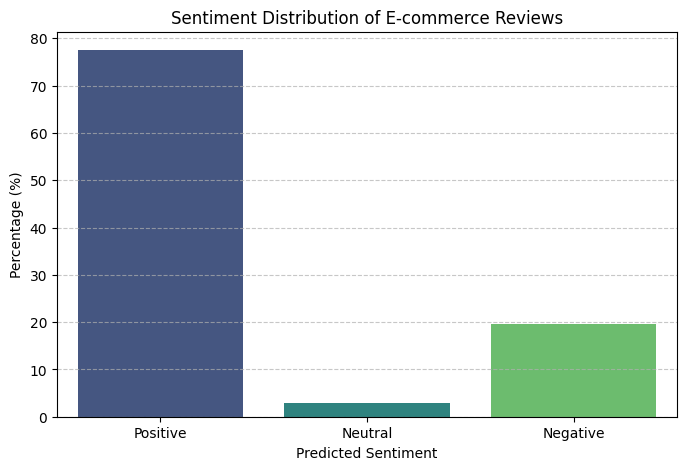


--- README & Slide Text ---
The analysis of the 356 successfully classified reviews revealed the following distribution: Positive (77.5%), Neutral (2.8%), Negative (19.7%).


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Cleaning Step (More Robust) ---

# 1. Create a working copy to avoid warnings
processed_df = sample_df.copy()

# 2. First, get the count of any rows that contain "Error" or are otherwise not one of our three labels.
initial_total = len(processed_df)
valid_labels = ['Positive', 'Neutral', 'Negative']
final_df = processed_df[processed_df['predicted_sentiment'].isin(valid_labels)]
final_total = len(final_df)
error_count = initial_total - final_total

print(f"--- Data Cleaning & Validation ---")
print(f"Total reviews processed: {initial_total}")
print(f"Successfully classified reviews (Positive, Neutral, or Negative): {final_total}")
print(f"Unclassified or Error reviews (ignored): {error_count}\n")


# --- Distribution Calculation (on fully cleaned data) ---
# This will now always sum to 100%
sentiment_distribution = final_df['predicted_sentiment'].value_counts(normalize=True) * 100

# Reindex to ensure a consistent order for the chart
order = ['Positive', 'Neutral', 'Negative']
sentiment_distribution = sentiment_distribution.reindex(order).fillna(0)

print("--- Overall Sentiment Distribution ---")
print(sentiment_distribution)


# --- Visualization (on fully cleaned data) ---
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette='viridis', order=order)
plt.title('Sentiment Distribution of E-commerce Reviews')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('sentiment_distribution_final.png')
plt.show()


# --- Tidy Text Generation ---
dist_text = "The analysis of the {count} successfully classified reviews revealed the following distribution: ".format(count=len(final_df))
for sentiment, percentage in sentiment_distribution.items():
    dist_text += "{s} ({p:.1f}%), ".format(s=sentiment, p=percentage)
dist_text = dist_text.strip(', ') + "."
print(dist_text)

In [14]:
# --- Model Performance Evaluation ---
# Note: This is a basic evaluation on a small sample for this proof-of-concept project.
correct_predictions = (sample_df['sentiment'] == sample_df['predicted_sentiment']).sum()
total_predictions = len(sample_df)
accuracy = (correct_predictions / total_predictions) * 100

print(f"\n--- Model Performance on Sample ---")
print(f"Correct Predictions: {correct_predictions} / {total_predictions}")
print(f"Accuracy: {accuracy:.2f}%")


--- Model Performance on Sample ---
Correct Predictions: 266 / 500
Accuracy: 53.20%


Confusion Matrix

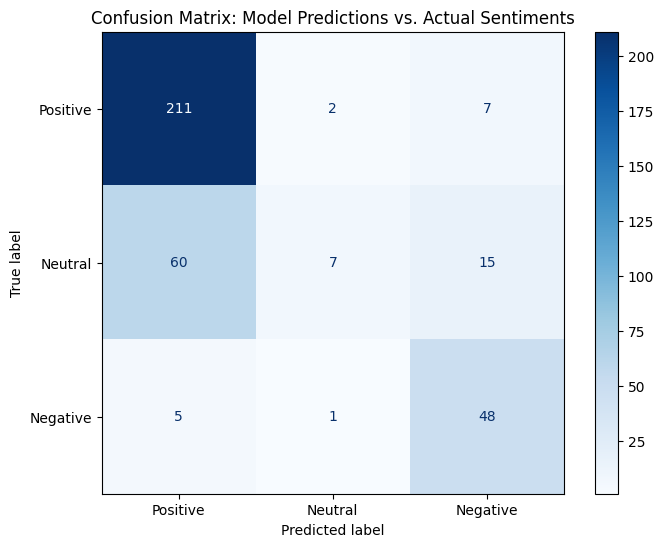

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure we are using the cleaned dataframe with valid predictions
# (This code assumes you have the 'valid_predictions_df' from the previous step)

# Define the true labels and the predicted labels
y_true = final_df['sentiment']
y_pred = final_df['predicted_sentiment']

# Define the order of labels for the matrix
labels = ['Positive', 'Neutral', 'Negative']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create the display plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Model Predictions vs. Actual Sentiments')
plt.savefig('confusion_matrix.png')
plt.show()

## 7. Identify Key Themes in Reviews

To support our qualitative findings, we can perform a simple keyword analysis to see which words are most common in each sentiment category. This helps validate themes like "fast shipping" or "product quality". We will use `CountVectorizer` from Scikit-learn to count word frequencies.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get the top N words from a series of texts
def get_top_n_words(corpus, n=10):
    # Note: We use basic English stop words. For a more advanced analysis,
    # a custom list including Indonesian stop words would be beneficial.
    vec = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Analyze Positive Reviews
positive_reviews = sample_df[sample_df['predicted_sentiment'] == 'Positive']['review']
top_positive_words = get_top_n_words(positive_reviews)
print("--- Top Keywords in Positive Reviews ---")
print(top_positive_words)

# Analyze Negative Reviews
negative_reviews = sample_df[sample_df['predicted_sentiment'] == 'Negative']['review']
top_negative_words = get_top_n_words(negative_reviews)
print("\n--- Top Keywords in Negative Reviews ---")
print(top_negative_words)

--- Top Keywords in Positive Reviews ---
[('good', np.int64(239)), ('product', np.int64(181)), ('quality', np.int64(143)), ('delivery', np.int64(99)), ('product quality', np.int64(98)), ('excellent', np.int64(82)), ('seller', np.int64(81)), ('speed', np.int64(76)), ('price', np.int64(71)), ('awesome', np.int64(63))]

--- Top Keywords in Negative Reviews ---
[('disappointed', np.int64(9)), ('money', np.int64(8)), ('quality', np.int64(7)), ('money money', np.int64(7)), ('goods', np.int64(7)), ('product', np.int64(7)), ('small', np.int64(6)), ('price', np.int64(5)), ('expensive', np.int64(5)), ('delivery', np.int64(5))]
